In [23]:
import torch

def normalize_rgb(x: torch.Tensor) -> torch.Tensor:
    """
    Normalize a tensor of image data in the range of 0 to 1.
    Assumes input tensor x has any shape, but values represent color channels in the range typical for images.

    Parameters:
    x (torch.Tensor): The input tensor.

    Returns:
    torch.Tensor: The normalized tensor with values between 0 and 1.
    """
    min_val = torch.min(x)
    max_val = torch.max(x)
    return (x - min_val) / (max_val - min_val)


In [24]:
import segmentation_models_pytorch as smp

ENCODER = 'mobilenet_v2'
#ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    #encoder_weights=ENCODER_WEIGHTS, 
    classes=2, 
    activation=ACTIVATION,
)

In [25]:
#dummy_input = torch.zeros(1,3,512,512)
#dummy_input.shape

#deeplab.eval()

#deeplab(dummy_input).shape

In [26]:
import torch
import torch.nn as nn
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


#MODEL

def double_conv(input_channels, output_channels):
    return nn.Sequential(
      nn.Conv2d(input_channels, output_channels, kernel_size=(3,3), stride=1, padding=1),
      nn.BatchNorm2d(output_channels),
      nn.ReLU(inplace=True),
      nn.Conv2d(output_channels, output_channels, kernel_size=(3,3), stride=1, padding=1),
      nn.BatchNorm2d(output_channels),
      nn.ReLU(inplace=True)
    )

def up_conv(input_channels, output_channels):
    return nn.Sequential(
      nn.ConvTranspose2d(input_channels, output_channels, kernel_size=(2,2), stride=2),
      nn.BatchNorm2d(output_channels),
      nn.ReLU(inplace=True)
  )

class ForestSegmentation(nn.Module):
    def __init__(self, encoder_channel, decoder_channel, input_channels, bottom_channels, class_number):
        super().__init__()
        self.encoder_channel = encoder_channel
        self.decoder_channel = decoder_channel
        self.bottom_channels = bottom_channels
        self.class_number = class_number

        self.encoder1 = double_conv(input_channels, encoder_channel[0])

        self.encoder2 = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2),
                                      double_conv(encoder_channel[0], encoder_channel[1]))

        self.encoder3 = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2),
                                      double_conv(encoder_channel[1], encoder_channel[2]))

        self.encoder4 = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2),
                                      double_conv(encoder_channel[2], encoder_channel[3]))

        self.bottleneck = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2),
                                        double_conv(encoder_channel[3], bottom_channels))

        self.decoder1up = up_conv(bottom_channels, bottom_channels)
        self.decoder1 = double_conv(encoder_channel[3]+bottom_channels, decoder_channel[0])

        self.decoder2up = up_conv(decoder_channel[0], decoder_channel[0])
        self.decoder2 = double_conv(encoder_channel[2]+decoder_channel[0], decoder_channel[1])

        self.decoder3up = up_conv(decoder_channel[1], decoder_channel[1])
        self.decoder3 = double_conv(encoder_channel[1]+decoder_channel[1], decoder_channel[2])

        self.decoder4up = up_conv(decoder_channel[2], decoder_channel[2])
        self.decoder4 = double_conv(encoder_channel[0]+decoder_channel[2], decoder_channel[3])

        self.classifier = nn.Conv2d(decoder_channel[3], class_number, kernel_size=(1,1))

    def forward(self, x):

        # Encoder
        encoder1 = self.encoder1(x)
        encoder2 = self.encoder2(encoder1)
        encoder3 = self.encoder3(encoder2)
        encoder4 = self.encoder4(encoder3)

        # Bottleneck
        x = self.bottleneck(encoder4)

        # Decoder
        x = self.decoder1up(x)
        x = torch.concat([x, encoder4], dim=1)
        x = self.decoder1(x)

        x = self.decoder2up(x)
        x = torch.concat([x, encoder3], dim=1)
        x = self.decoder2(x)

        x = self.decoder3up(x)
        x = torch.concat([x, encoder2], dim=1)
        x = self.decoder3(x)

        x = self.decoder4up(x)
        x = torch.concat([x, encoder1], dim=1)
        x = self.decoder4(x)

        # Classifier head
        x = self.classifier(x)

        return x
    


# CREATE MODEL SINGLETONE 
unet = ForestSegmentation(encoder_channel=[16,32,64,128], 
                             decoder_channel=[128,64,32,16], 
                             input_channels=3, 
                             bottom_channels=256, 
                             class_number=2)

In [33]:
DEVICE = 'cuda' if torch.cuda.is_available else 'cpu'

best_weight = torch.load('./deeplab_rgb_forest_segmentation_model_0.9023073315620422_iou.pt', map_location=DEVICE)
model.load_state_dict(best_weight)

model.eval()


best_weight_unet = torch.load('./rgb_forest_segmentation_model_0.9154245853424072_iou.pt', map_location=DEVICE)
unet.load_state_dict(best_weight_unet)

unet.eval()

# PLACE INTO API CALL

# Path to your image
image_path = './dataset/map-screenshot(23).png'

# Load the image
image = Image.open(image_path)

# Check if the image is not in 'RGB' mode
if image.mode != 'RGB':
    image = image.convert('RGB')

# Define the transformation: resize to 512x512 and convert to tensor
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize the image to 512x512
    transforms.ToTensor()           # Convert the image to a PyTorch tensor
])

# Apply the transformation
tensor_image = transform(image)

#tensor_image = normalize_rgb(tensor_image)


# Now tensor_image is a PyTorch tensor ready to be used in your model

with torch.no_grad():
    # Predict
    prediction = model(tensor_image.unsqueeze(0))
    prediction_unet = unet(tensor_image.unsqueeze(0))
    

    #print(prediction.shape)

    predicted_mask = torch.argmax(prediction[0], axis=0)
    predicted_mask_unet = torch.argmax(prediction_unet[0], axis=0)

    #print(predicted_mask.shape)

    #print(type(predicted_mask))
            
            
if predicted_mask.dtype != torch.float32:
    predicted_mask = predicted_mask.float()  # Convert tensor to float
            
            
model_output = predicted_mask.unsqueeze(0)  # Shape becomes [1, 512, 512]


# Make sure your tensor is on CPU and has the right type
tensor = model_output.cpu()


# Since tensor is 0s and 1s, we directly multiply by 255 to match uint8 image range
tensor = tensor.mul(255).byte()

# Convert tensor to a PIL image
# The tensor should be squeezed to remove the channel dimension if it's singular
image = Image.fromarray(tensor.squeeze(0).numpy())

# Save the image
image.save('kek.png')


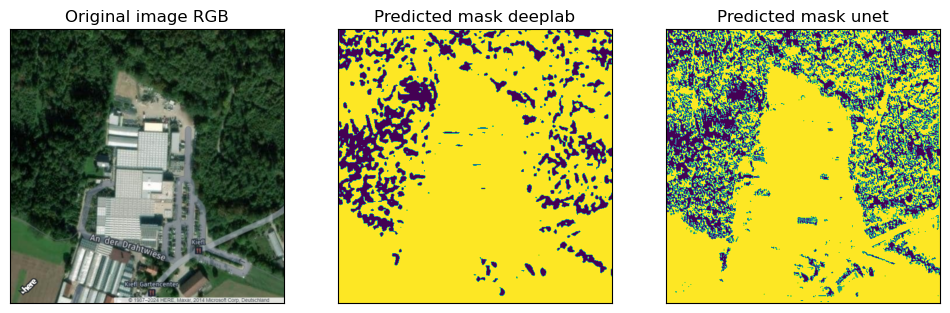

In [34]:
# Visualize
plt.figure(figsize=(12,8))

rgb_image = np.transpose(tensor_image, (1, 2, 0))

# Normalize rgb image
rgb_image = normalize_rgb(rgb_image)

# RGB image
plt.subplot(1, 3, 1)
plt.imshow(rgb_image)
plt.title('Original image RGB')
plt.xticks([])
plt.yticks([])

# Predicted mask
plt.subplot(1, 3, 2)
plt.imshow(predicted_mask)
plt.title('Predicted mask deeplab')
plt.xticks([])
plt.yticks([])

# Predicted mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_unet)
plt.title('Predicted mask unet')
plt.xticks([])
plt.yticks([])

plt.show()